---
title: Deep Learning Code
author: Xinyue Ji
format:
  html:
    toc: true
    embed-resources: true
jupyter: python3
---

In [483]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras import optimizers
import math
from sklearn.metrics import mean_squared_error

### Loading Data


In [484]:
tf.random.set_seed(123)

In [485]:
## read temperature data
temp_data = pd.read_csv('Timeseries_Dataset/data/1900-2022.csv',usecols=[0,1]) ## only keep the tempature data
data = np.array(temp_data["Value"].values.astype('float32')).reshape(temp_data.shape[0],1)
print(temp_data.head)

<bound method NDFrame.head of         Year  Value
0     190001  -0.31
1     190002  -0.06
2     190003  -0.03
3     190004  -0.09
4     190005  -0.06
...      ...    ...
1471  202208   0.91
1472  202209   0.88
1473  202210   0.90
1474  202211   0.75
1475  202212   0.80

[1476 rows x 2 columns]>


### Plot the data


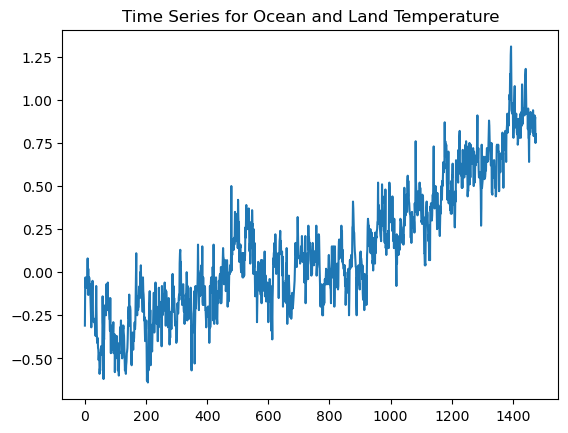

In [486]:
plt.plot(data)
plt.title("Time Series for Ocean and Land Temperature")
plt.show()

### Preparing Train and Test Data


In [487]:
#data = temp_data.values
#data = data.astype('float32')
## normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [488]:
## split the temperature data into train and test data set
train = int(len(data) * 0.75)
test = len(data) - train
train_set= data[0:train,:]
test_set = data[train:len(data),:]
print(len(train_set))
print(len(test_set))

## convert array to X,Y 
def create_x_y(data,lookback = 1):
    X,Y = [],[]
    index = len(data) - lookback - 1
    for i in range(index):
        row = data[i:(i+lookback),0]
        X.append(row)
        Y.append(data[i+lookback,0])
    return np.array(X),np.array(Y)
create_x_y(data)


1107
369


(array([[0.16923077],
        [0.2974359 ],
        [0.31282052],
        ...,
        [0.7948718 ],
        [0.77948725],
        [0.7897436 ]], dtype=float32),
 array([0.2974359 , 0.31282052, 0.2820513 , ..., 0.77948725, 0.7897436 ,
        0.71282053], dtype=float32))

In [489]:
X,Y = create_x_y(data)
print(X.shape)
print(Y.shape)

(1474, 1)
(1474,)


In [490]:
## reshape the data
step = 1
x_train,y_train = create_x_y(train_set, step)
x_test, y_test = create_x_y(test_set, step)
# reshape the data to [samples, time steps, features] to fit for modeling
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

### Plot and RMSE function

In [491]:
def plot_history(metric="loss",skip=0): 
    history_dict = history.history
    loss_values = history_dict[metric]
    val_loss_values = history_dict["val_"+metric]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs[skip:], loss_values[skip:], "bo", label="Training "+metric)
    plt.plot(epochs[skip:], val_loss_values[skip:], "b", label="Validation "+metric)
    plt.title("Training and validation "+metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

def print_error(y_train, y_test, train_pred, test_pred):    
    train_rmse = math.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = math.sqrt(mean_squared_error(y_test, test_pred))
    #print('Train RMSE: %.3f RMSE' % (train_rmse))
    #print('Test RMSE: %.3f RMSE' % (test_rmse))
    return train_rmse, test_rmse

### RNN Model


In [492]:
epochs = 200
batch_size = 25

In [493]:
model_rnn = keras.models.Sequential() 
model_rnn.add(keras.layers.SimpleRNN(64,input_shape = (step,1)))
model_rnn.add(layers.Dense(32, activation='softmax'))
model_rnn.add(layers.Dense(1))
model_rnn.summary()
model_rnn.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(),metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_25 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_131 (Dense)           (None, 32)                2080      
                                                                 
 dense_132 (Dense)           (None, 1)                 33        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [494]:
history = model_rnn.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, validation_split=0.2,verbose=1)

Epoch 1/200
36/36 [==============================] - 1s 6ms/step - loss: 0.0640 - root_mean_squared_error: 0.2529 - val_loss: 0.1077 - val_root_mean_squared_error: 0.3282
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2085
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1606
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1411
Epoch 5/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0096 - val_root_m

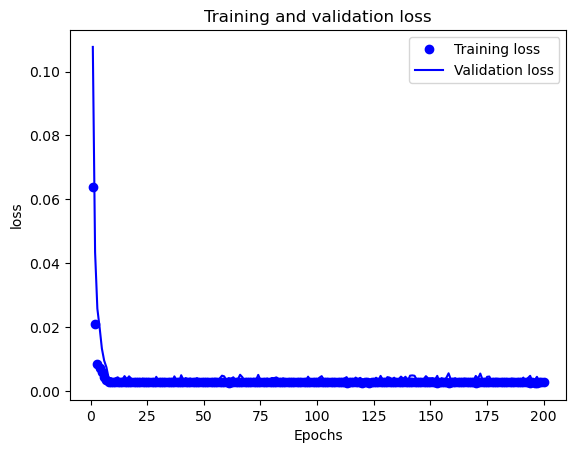

In [495]:
## plot loss for RNN model
plot_history("loss")

In [496]:
## predict for test data and evaluate the RNN model
pred1 = model_rnn.evaluate(x_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 0.0269 - root_mean_squared_error: 0.1641


In [497]:
train_pred1 = model_rnn.predict(x_train)
test_pred1 = model_rnn.predict(x_test)

train_rmse1,test_rmse1 = print_error(y_train, y_test, train_pred1, test_pred1)
rmse_result = {'Model': 'RNN','Train RMSE': [train_rmse1], 'Test RMSE': [test_rmse1], 'Validation RMSE': np.mean(history.history['val_root_mean_squared_error']),
                'Train Loss':np.mean(history.history['loss']),'Validation Loss':np.mean(history.history['val_loss'])}
rmse_result = pd.DataFrame(rmse_result)
display(rmse_result)

,Model,Train RMSE,Test RMSE,Validation RMSE,Train Loss,Validation Loss
0,RNN,0.053209,0.164139,0.063937,0.003194,0.004674


### RNN with Regularization


In [498]:
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import L1L2
model_rnnr = keras.models.Sequential() 
model_rnnr.add(keras.layers.SimpleRNN(64,input_shape = (step,1),recurrent_regularizer=regularizers.L1(0.01)))
model_rnnr.add(layers.Dense(32, activation='sigmoid'))
model_rnnr.add(layers.Dense(1))
model_rnnr.summary()
model_rnnr.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(),metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_133 (Dense)           (None, 32)                2080      
                                                                 
 dense_134 (Dense)           (None, 1)                 33        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [499]:
history = model_rnnr.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, validation_split=0.2,verbose=1)

Epoch 1/200
36/36 [==============================] - 2s 5ms/step - loss: 3.2403 - root_mean_squared_error: 0.2251 - val_loss: 2.5308 - val_root_mean_squared_error: 0.1199
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 2.0585 - root_mean_squared_error: 0.0696 - val_loss: 1.6110 - val_root_mean_squared_error: 0.0838
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 1.2845 - root_mean_squared_error: 0.0588 - val_loss: 0.9816 - val_root_mean_squared_error: 0.1060
Epoch 4/200
36/36 [==============================] - 0s 1ms/step - loss: 0.7557 - root_mean_squared_error: 0.0559 - val_loss: 0.5531 - val_root_mean_squared_error: 0.0604
Epoch 5/200
36/36 [==============================] - 0s 1ms/step - loss: 0.4211 - root_mean_squared_error: 0.0549 - val_loss: 0.3004 - val_root_mean_squared_error: 0.0483
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.0537 - val_loss: 0.1627 - val_root_m

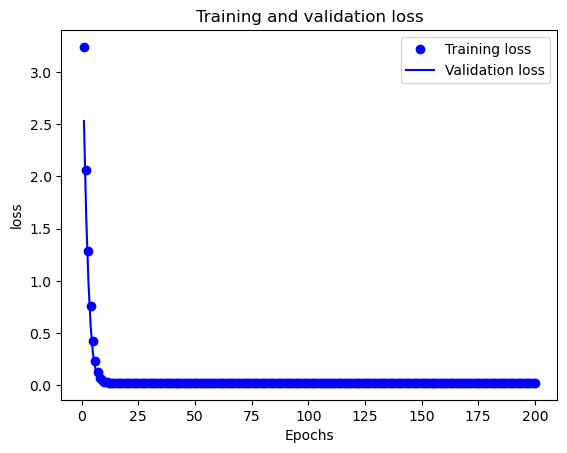

In [500]:
## plot loss and accuracy for model
plot_history("loss")

In [501]:
train_pred2 = model_rnnr.predict(x_train)
test_pred2 = model_rnnr.predict(x_test)

train_rmse2,test_rmse2 = print_error(y_train, y_test, train_pred2, test_pred2)
rmse_result2 = {'Model': 'RNN with Regularization','Train RMSE': [train_rmse2], 'Test RMSE': [test_rmse2], 'Validation RMSE': np.mean(history.history['val_root_mean_squared_error']),
                'Train Loss':np.mean(history.history['loss']),'Validation Loss':np.mean(history.history['val_loss'])}
rmse_result2 = pd.DataFrame(rmse_result2)
display(rmse_result2)

,Model,Train RMSE,Test RMSE,Validation RMSE,Train Loss,Validation Loss
0,RNN with Regularization,0.05321,0.090209,0.058946,0.062291,0.053465


In [502]:
## predict for test data and evaluate the RNN with Regularization model
pred2 = model_rnnr.evaluate(x_test, y_test)

12/12 [==============================] - 0s 828us/step - loss: 0.0274 - root_mean_squared_error: 0.0902


### GRU Model


In [503]:
model_gru = keras.models.Sequential() 
model_gru.add(keras.layers.GRU(64,input_shape = (step,1))) 
model_gru.add(keras.layers.Dense(16, activation='sigmoid'))
model_gru.add(layers.Dense(1))
model_gru.summary()
model_gru.compile(optimizer=optimizers.RMSprop(), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_27 (GRU)                (None, 64)                12864     
                                                                 
 dense_135 (Dense)           (None, 16)                1040      
                                                                 
 dense_136 (Dense)           (None, 1)                 17        
                                                                 
Total params: 13,921
Trainable params: 13,921
Non-trainable params: 0
_________________________________________________________________


In [504]:
history = model_gru.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, validation_split=0.2,verbose=1)

Epoch 1/200
36/36 [==============================] - 1s 9ms/step - loss: 0.0755 - root_mean_squared_error: 0.2748 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1771
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1259
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 5/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0028 - val_root_m

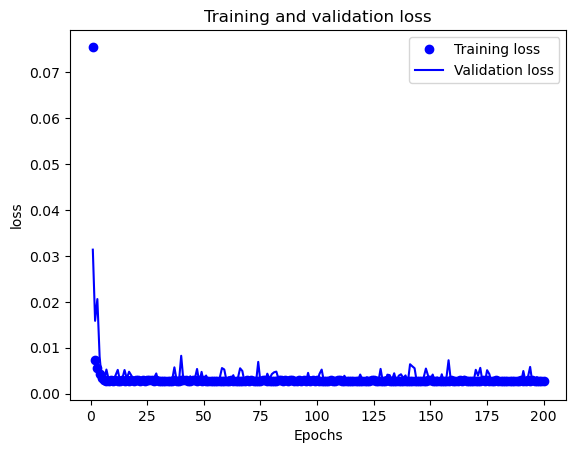

In [505]:
## plot loss for model
plot_history("loss")

In [506]:
## predict for test data and evaluate the GRU model
pred3 = model_gru.evaluate(x_test, y_test)

12/12 [==============================] - 0s 816us/step - loss: 0.0064 - root_mean_squared_error: 0.0800


In [507]:
## evaluate the model with loss and rmse
train_pred3 = model_gru.predict(x_train)
test_pred3 = model_gru.predict(x_test)

train_rmse3,test_rmse3 = print_error(y_train, y_test, train_pred3, test_pred3)
rmse_result3 = {'Model': 'GRU','Train RMSE': [train_rmse3], 'Test RMSE': [test_rmse3], 'Validation RMSE': np.mean(history.history['val_root_mean_squared_error']),
                'Train Loss':np.mean(history.history['loss']),'Validation Loss':np.mean(history.history['val_loss'])}
rmse_result3 = pd.DataFrame(rmse_result3)
display(rmse_result3)

,Model,Train RMSE,Test RMSE,Validation RMSE,Train Loss,Validation Loss
0,GRU,0.052446,0.080039,0.058391,0.003252,0.003622


### GRU Model with Regularization


In [508]:
model_grur = keras.models.Sequential() 
model_grur.add(keras.layers.GRU(64,recurrent_dropout=0.2,input_shape = (step,1),recurrent_regularizer=regularizers.L2(0.01))) 
model_grur.add(keras.layers.Dense(16, activation='sigmoid'))
model_grur.add(layers.Dense(1))
model_grur.summary()
model_grur.compile(optimizer=optimizers.RMSprop(), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, 64)                12864     
                                                                 
 dense_137 (Dense)           (None, 16)                1040      
                                                                 
 dense_138 (Dense)           (None, 1)                 17        
                                                                 
Total params: 13,921
Trainable params: 13,921
Non-trainable params: 0
_________________________________________________________________


In [509]:
history = model_grur.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, validation_split=0.2,verbose=1)

Epoch 1/200
36/36 [==============================] - 2s 10ms/step - loss: 0.6022 - root_mean_squared_error: 0.4689 - val_loss: 0.2447 - val_root_mean_squared_error: 0.1260
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 0.1726 - root_mean_squared_error: 0.1429 - val_loss: 0.1336 - val_root_mean_squared_error: 0.2134
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0694 - root_mean_squared_error: 0.1199 - val_loss: 0.0809 - val_root_mean_squared_error: 0.2283
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0282 - root_mean_squared_error: 0.1070 - val_loss: 0.0420 - val_root_mean_squared_error: 0.1852
Epoch 5/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0132 - root_mean_squared_error: 0.0949 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1373
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0075 - root_mean_squared_error: 0.0818 - val_loss: 0.0133 - val_root_

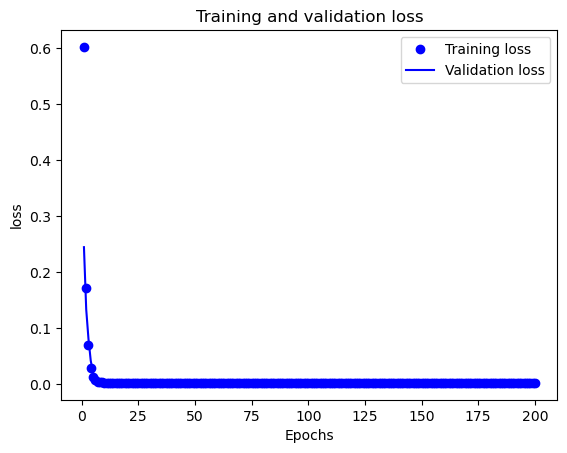

In [510]:
## plot loss for model
plot_history("loss")

In [511]:
## predict for test data and evaluate the GRU with Regularization model
pred4 = model_grur.evaluate(x_test, y_test)

12/12 [==============================] - 0s 962us/step - loss: 0.0072 - root_mean_squared_error: 0.0847


In [512]:
## evaluate the model with loss and rmse
train_pred4 = model_grur.predict(x_train)
test_pred4 = model_grur.predict(x_test)

train_rmse4,test_rmse4 = print_error(y_train, y_test, train_pred4, test_pred4)
rmse_result4 = {'Model': 'GRU with Regularization','Train RMSE': [train_rmse4], 'Test RMSE': [test_rmse4], 'Validation RMSE': np.mean(history.history['val_root_mean_squared_error']),
                'Train Loss':np.mean(history.history['loss']),'Validation Loss':np.mean(history.history['val_loss'])}
rmse_result4 = pd.DataFrame(rmse_result4)
display(rmse_result4)

,Model,Train RMSE,Test RMSE,Validation RMSE,Train Loss,Validation Loss
0,GRU with Regularization,0.052412,0.084676,0.060019,0.007262,0.005899


### LSTM Model


In [513]:
model_lstm = keras.models.Sequential() 
model_lstm.add(keras.layers.LSTM(64,input_shape=(1,step)))
model_lstm.add(layers.Dense(4, activation='sigmoid'))
model_lstm.compile(optimizer=optimizers.RMSprop(), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
model_lstm.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 64)                16896     
                                                                 
 dense_139 (Dense)           (None, 4)                 260       
                                                                 
Total params: 17,156
Trainable params: 17,156
Non-trainable params: 0
_________________________________________________________________


In [514]:
history = model_lstm.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, validation_split=0.2,verbose=1)

Epoch 1/200
36/36 [==============================] - 1s 9ms/step - loss: 0.0536 - root_mean_squared_error: 0.2315 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0382 - root_mean_squared_error: 0.1954 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1027
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1462
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0160 - root_mean_squared_error: 0.1265 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1871
Epoch 5/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0134 - root_mean_squared_error: 0.1160 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1972
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.0396 - val_root_m

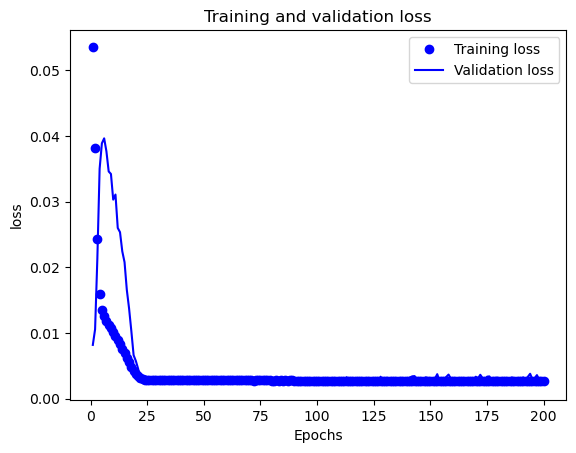

In [515]:
## plot loss for model
plot_history("loss")

In [516]:
## predict for test data and evaluate the LSTM model
pred5 = model_lstm.evaluate(x_test, y_test)

12/12 [==============================] - 0s 810us/step - loss: 0.0200 - root_mean_squared_error: 0.1413


In [517]:
## evaluate the model with loss and rmse
train_pred5 = model_lstm.predict(x_train)
test_pred5 = model_lstm.predict(x_test)

#train_rmse5,test_rmse5 = print_error(y_train, y_test, train_pred5, test_pred5)
rmse_result5 = pd.DataFrame({'Model': 'LSTM','Train RMSE': np.mean(history.history['root_mean_squared_error']), 'Test RMSE': '0.1413', 'Validation RMSE': np.mean(history.history['val_root_mean_squared_error']),
                'Train Loss':np.mean(history.history['loss']),'Validation Loss':np.mean(history.history['val_loss'])},index=[0])
display(rmse_result5)

,Model,Train RMSE,Test RMSE,Validation RMSE,Train Loss,Validation Loss
0,LSTM,0.058021,0.1413,0.062804,0.003818,0.004914


### LSTM Model with Regularization


In [518]:
model_lstmr = keras.models.Sequential() 
model_lstmr.add(keras.layers.LSTM(64,input_shape=(1,step), recurrent_regularizer=regularizers.L2(0.01)))
model_lstm.add(layers.Dropout(0.1)) 
model_lstmr.add(layers.Dense(4, activation='softmax'))
model_lstmr.compile(optimizer=optimizers.RMSprop(), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
model_lstmr.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                16896     
                                                                 
 dense_140 (Dense)           (None, 4)                 260       
                                                                 
Total params: 17,156
Trainable params: 17,156
Non-trainable params: 0
_________________________________________________________________


In [519]:
history = model_lstmr.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, validation_split=0.2,verbose=1)

Epoch 1/200
36/36 [==============================] - 1s 10ms/step - loss: 0.3689 - root_mean_squared_error: 0.1071 - val_loss: 0.2423 - val_root_mean_squared_error: 0.2119
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 0.1356 - root_mean_squared_error: 0.1071 - val_loss: 0.1104 - val_root_mean_squared_error: 0.2119
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0497 - root_mean_squared_error: 0.1071 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2119
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0211 - root_mean_squared_error: 0.1071 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2119
Epoch 5/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0134 - root_mean_squared_error: 0.1071 - val_loss: 0.0456 - val_root_mean_squared_error: 0.2119
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 0.0118 - root_mean_squared_error: 0.1071 - val_loss: 0.0450 - val_root_

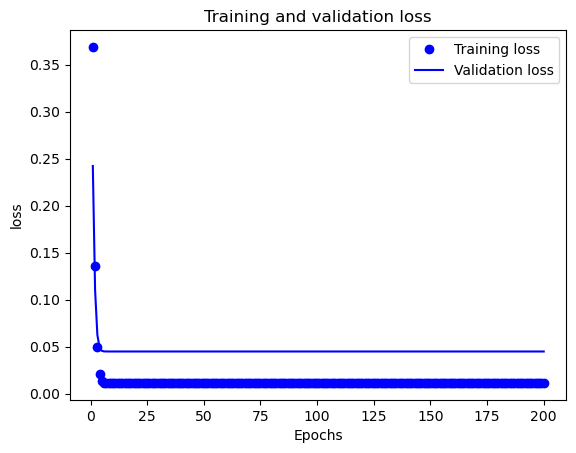

In [520]:
## plot loss for model
plot_history("loss")

In [521]:
## predict for test data and evaluate the LSTM with Regularization model
pred6 = model_lstmr.evaluate(x_test, y_test)

12/12 [==============================] - 0s 1ms/step - loss: 0.1782 - root_mean_squared_error: 0.4221


In [522]:
## evaluate the model with loss and rmse
train_pred6 = model_lstmr.predict(x_train)
test_pred6 = model_lstmr.predict(x_test)

#train_rmse6,test_rmse6 = print_error(y_train, y_test, train_pred6, test_pred6)
rmse_result6 = pd.DataFrame({'Model': 'LSTM with Regularization','Train RMSE': np.mean(history.history['root_mean_squared_error']),'Test RMSE':'0.4221', 'Validation RMSE': np.mean(history.history['val_root_mean_squared_error']),
                'Train Loss':np.mean(history.history['loss']),'Validation Loss':np.mean(history.history['val_loss'])},index=[0])
display(rmse_result6)

,Model,Train RMSE,Test RMSE,Validation RMSE,Train Loss,Validation Loss
0,LSTM with Regularization,0.107141,0.4221,0.211935,0.014177,0.046382


### Comparison

In [523]:
## merge all tables together
frames = [rmse_result,rmse_result2,rmse_result3,rmse_result4,rmse_result5,rmse_result6]
table_final = pd.concat(frames,ignore_index=True)
display(table_final)
table_final.to_csv('Timeseries_Dataset/data/deep_learning_result.csv',index=False)

,Model,Train RMSE,Test RMSE,Validation RMSE,Train Loss,Validation Loss
0,RNN,0.053209,0.164139,0.063937,0.003194,0.004674
1,RNN with Regularization,0.053210,0.090209,0.058946,0.062291,0.053465
2,GRU,0.052446,0.080039,0.058391,0.003252,0.003622
3,GRU with Regularization,0.052412,0.084676,0.060019,0.007262,0.005899
4,LSTM,0.058021,0.1413,0.062804,0.003818,0.004914
5,LSTM with Regularization,0.107141,0.4221,0.211935,0.014177,0.046382


reference: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/